In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [2]:
# This is needed to display the images.
%matplotlib inline

### Object Detection imports

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/host/Work/Playground/Docker_exp/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


### Allowed subset of classes
 - Note: There are more classes in Berkeley Deep Drive dataset. Please visit [this](https://bdd-data.berkeley.edu/) for more details

In [4]:
allowed_classes = [
    {
        'id': 19,
        'name': 'parking sign'
    },
    {
        'id': 20,
        'name': 'pole'
    },
    {
        'id': 21,
        'name': 'polegroup'
    },
    {
        'id': 22,
        'name': 'street light'
    },
    {
        'id': 23,
        'name': 'traffic cone'
    },
    {
        'id': 24,
        'name': 'traffic device'
    },
    {
        'id': 25,
        'name': 'traffic light'
    },
    {
        'id': 26,
        'name': 'traffic sign'
    },
    {
        'id': 27,
        'name': 'traffic sign frame'
    },
    {
        'id': 31,
        'name': 'person'
    },
    {
        'id': 32,
        'name': 'rider'
    },
    {
        'id': 33,
        'name': 'bicycle'
    },
    {
        'id': 34,
        'name': 'bus'
    },
    {
        'id': 35,
        'name': 'car'
    },
    {
        'id': 36,
        'name': 'caravan'
    },
    {
        'id': 37,
        'name': 'motorcycle'
    },
    {
        'id': 38,
        'name': 'trailer'
    },
    {
        'id': 39,
        'name': 'train'
    },
    {
        'id': 40,
        'name': 'truck'
    }
]

In [5]:
def extract_annotationsList_from_segmented_images(image_id, instance_id_png, object_id_png, allowed_classes):
    """Extracts annotation list, as required by tf Object Detection API, for a given image represented by (instance_id_png, object_id_png).
      Where:
      - image_id: numeric id of the image for which these segmentation masks are given
      - instance_id_png: file path having instance ids in PNG format
      - object_id_png: file path having object ids in PNG format
      - allowed_classes: list dictionaries keyed by {id, name} of classes to be allowed for extraction
      
      Returns: annotation list, which is basically a list of dictionaries, each with following keys
                'segmentation': 2D segmented image (numpy.ndarray) which is basically a binary array for every instance
                'area': area of bounding box 
                'iscrowd': set always True 
                'image_id': 'id' field of corresponding image 
                'bbox': (x, y, width, height) 
                'category_id': object class within this bbox
    """
    annotations_list = []
    allowed_ids = set([cls['id'] for cls in allowed_classes])
    inst_ids = np.asarray(Image.open(instance_id_png))
    obj_ids = np.asarray(Image.open(object_id_png))
    unique_insts = np.unique(inst_ids)
    for inst_id in unique_insts:
        objID_mask = np.where(inst_ids == inst_id, obj_ids, 0)
        boolean_mask = np.where(objID_mask > 0, 1, 0)
        max_occuring_objID = np.argmax(np.bincount(objID_mask[objID_mask > 0]))
        if max_occuring_objID in allowed_ids:
            valid_rows, valid_cols = np.where(boolean_mask > 0)
            y_min, y_max = np.min(valid_rows), np.max(valid_rows)
            x_min, x_max = np.min(valid_cols), np.max(valid_cols)
            bbox = (x_min, y_min, x_max - x_min, y_max - y_min)
            area = bbox[2] * bbox[3]
            annotation = {
                'segmentation': boolean_mask,
                'area': area,
                'iscrowd': True,
                'image_id': image_id,
                'bbox': bbox,
                'category_id': max_occuring_objID
            }
            annotations_list.append(annotation)
        
    return annotations_list

### Testing a sample

In [6]:
raw_image = 'test_images/BerkeleyDeepDrive/raw_images/0a1d6940-9acdbf50.jpg'
instance_id_png = 'test_images/BerkeleyDeepDrive/instance_id/0a1d6940-9acdbf50.png'
object_id_png = 'test_images/BerkeleyDeepDrive/class_id/0a1d6940-9acdbf50.png'
annotations_list = extract_annotationsList_from_segmented_images(1, instance_id_png, object_id_png, allowed_classes)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


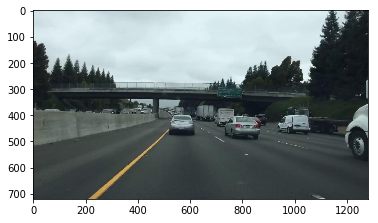

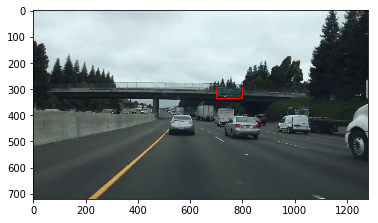

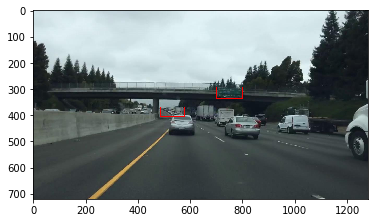

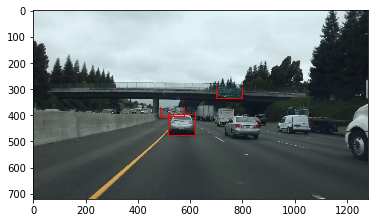

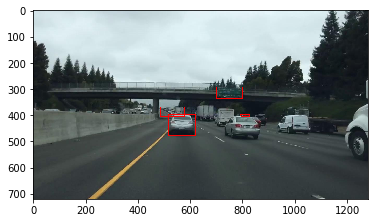

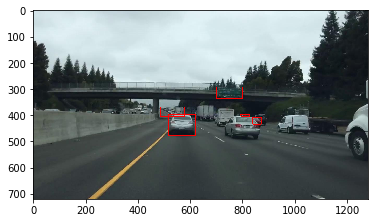

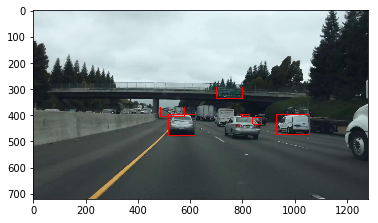

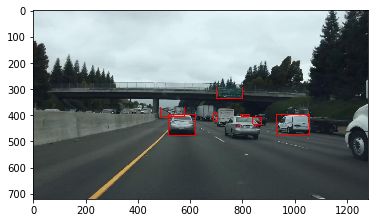

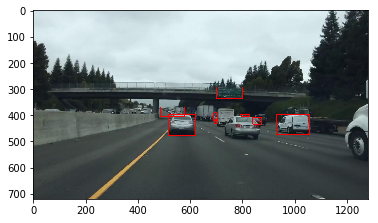

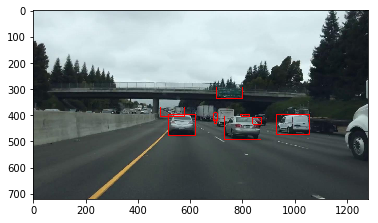

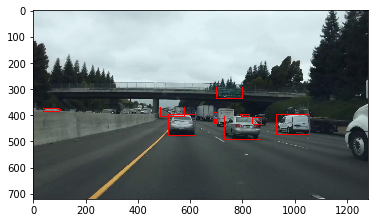

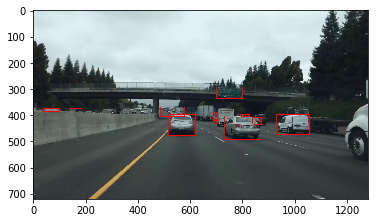

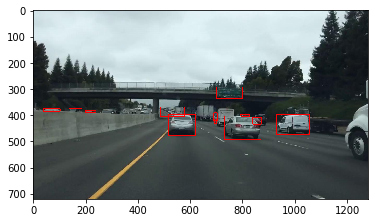

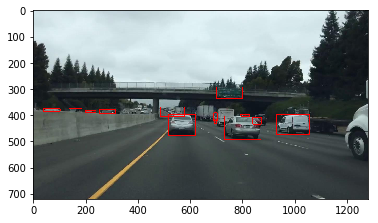

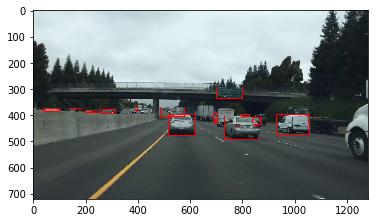

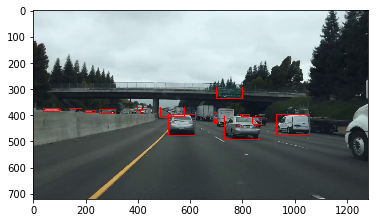

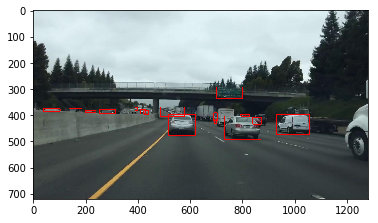

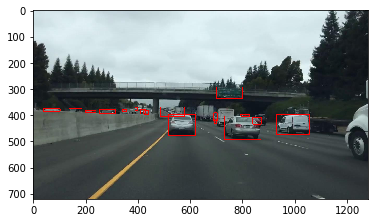

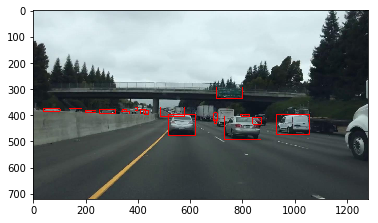

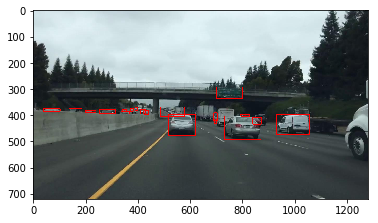

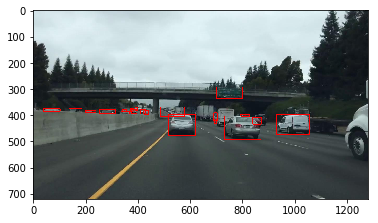

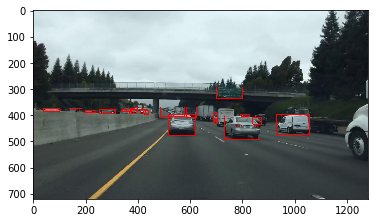

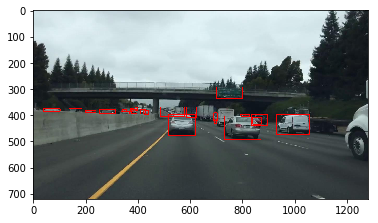

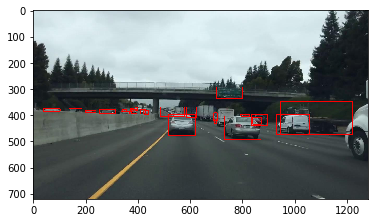

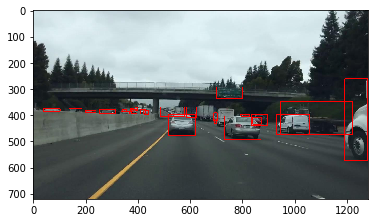

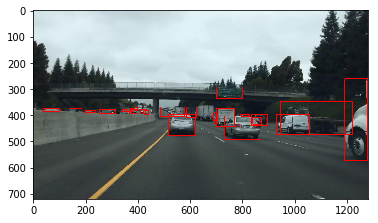

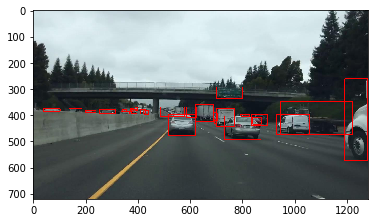

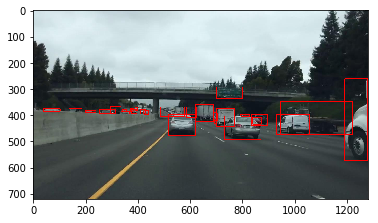

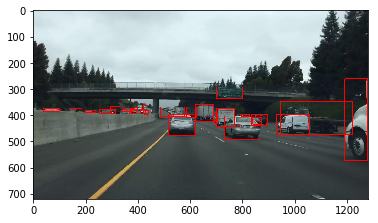

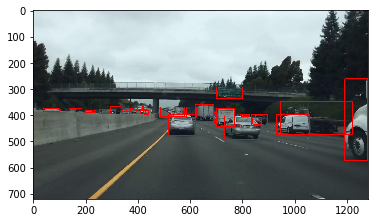

In [32]:
import cv2 as cv
img = cv.imread(raw_image)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
for annotation in annotations_list:
    x1,y1,w,h = annotation['bbox']
    x2,y2 = x1+w, y1+h
    cv.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(img)